# DSE 10 Homework 4 - Due 02/05/2021 9:00am

## Instructions
* Please upload all work to gradescope by the due date - **late work will not be graded**
    * You should submit a single ipynb file containing all your code and output (plots, numeric values, etc...)
    * Important: **name your ipynb file according to the following convention**: `<lastname>_<firstname>.ipynb` - example: (`thomas_anthony.ipynb`)
    * Please organize your notebook into sections by problem
    * Use print statements to clearly indicate which question you are ansering
        * Good: `print("Problem 4 (e): {}".format(np.pi))`
        * Good: `print("The value of pi is: {}".format(np.pi))`
        * Bad:  `print(np.pi)`
        * Bad:  `np.pi`
    * Use relative paths to load data:
        * Good: `loadmnist("train-images-idx3-ubyte", "train-labels-idx1-ubyte")`
        * Bad: `loadmnist("/home/anthony/class/DSE10/train-images-idx3-ubyte", ...)`
* Collaboration is encouraged, but all submissions should be in your own writing/code and written with your own understanding
* Your code must run and be able to reproduce your answers
* Unless stated otherwise in the assignemnt, your code should use only basic low-level NumPy/SciPy linear algebra and satistics commands (e.g. do not use built in estimation tools or anything from SciKitLearn). When in doubt, ask for clarification on Canvas.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.cluster as cluster
import matplotlib.pyplot as plt

from struct import unpack
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

np.random.seed(12345)

In [2]:
def loadmnist(imagefile, labelfile):

    # Open the images with gzip in read binary mode
    images = open(imagefile, 'rb')
    labels = open(labelfile, 'rb')

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack('>I', N)[0]

    # Get data
    x = np.zeros((N, rows*cols), dtype=np.uint8)  # Initialize numpy array
    y = np.zeros(N, dtype=np.uint8)  # Initialize numpy array
    for i in range(N):
        for j in range(rows*cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack('>B', tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]

    images.close()
    labels.close()
    return (x, y)

# Worksheet 9 Problem 3

In [3]:
def eval_model(X, multinomial_probs, class_priors):
    docs = X["doc_id"].drop_duplicates().values
    num_topics, num_words = multinomial_probs.shape
    predicted = np.zeros(docs.size)
    X = X.reset_index().set_index("doc_id")
    for ix in docs:
        D = X.loc[ix,:]
        doc_counts = np.zeros(num_words)
        doc_counts[D["word_id"].values-1] = D["count"].values
        probs = np.zeros(num_topics)
        for t in range(num_topics):
            probs[t] = np.log(class_priors[t])+np.sum(doc_counts * multinomial_probs[t,:])
        predicted[ix-1] = np.argmax(probs)+1

    return predicted

## Read in data and match documents with labels 

In [4]:
num_words = 61188
num_topics = 20

colnames = ["doc_id", "word_id", "count"]
pref = "../data/20news-bydate/matlab/"
X = pd.read_csv(pref + "train.data", delimiter=" ", names=colnames)
y = pd.read_csv(pref + "train.label", delimiter=" ", names=["topic_id"])

y["doc_id"] = X["doc_id"].drop_duplicates().values
X = X.set_index("doc_id").join(
        y.set_index("doc_id")
    ).reset_index().set_index("topic_id")

## Estimate multinomial parameters for each topic

In [5]:
multinomial_probs = np.zeros((num_topics, num_words))
for t in range(num_topics):
    X_t = X.loc[t+1, ["word_id","count"]].groupby("word_id")["count"].sum()
    counts = np.zeros(num_words)
    counts[X_t.index.values-1] = X_t.values
    multinomial_probs[t,:] = (counts + 1)/ (counts.sum() + num_words)
multinomial_probs = np.log(multinomial_probs)

docs = X.reset_index().loc[:,["topic_id","doc_id"]].drop_duplicates()
class_priors = docs.groupby("topic_id")["doc_id"].count()
class_priors = (class_priors / class_priors.sum()).values

## Evaluate model on test set

In [6]:
X_test = pd.read_csv(pref + "test.data", delimiter=" ", names=colnames)
y_test = pd.read_csv(pref + "test.label", delimiter=" ", names=["topic_id"])

y_hat_test = eval_model(X_test, multinomial_probs, class_priors)
print("NewsGroup Test Accuracy: {}".format(
    np.mean(y_hat_test == y_test["topic_id"].values)))

NewsGroup Test Accuracy: 0.7810792804796802


# Worksheet 9 Problem 4

In [7]:
def fit_gaussians(x_train, y_train, s):
    class_dists = []
    for y in range(10):
        X = x_train[y_train == y,:]
        mu = X.mean(axis=0)
        sigma = np.cov(X, rowvar=False) + s*np.eye(mu.size)
        class_dists.append(stats.multivariate_normal(mean=mu, cov=sigma))
    
    return class_dists


def compute_posterior_prob(x, class_dists, class_priors):
    probs = []
    for p,d in zip(class_priors, class_dists):
        probs.append((p + d.logpdf(x)).reshape(-1,1))
    
    return np.concatenate(probs, axis=1)

## Read in data

In [8]:
pref = "../data/mnist/"
x_train, y_train = loadmnist(pref + "train-images.idx3-ubyte", 
                             pref + "train-labels.idx1-ubyte")
x_test, y_test   = loadmnist(pref + "t10k-images.idx3-ubyte", 
                             pref + "t10k-labels.idx1-ubyte")

## Estimate parameters of multivariate-Gaussians

Note: here we need to select the smoothing constant. To do this, we'll try a range of values
and evaluate the model accuract on a held out "validation sample" set aside from the training set.
We'll then pick the smoothing constant that maximizes the accuracy on the validation set.

In [9]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train)

In [10]:
class_priors = np.unique(y_train, return_counts=True)[1].astype(np.float64)
class_priors = np.log(class_priors / class_priors.sum())

smoothing_consts = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
validation_accuracy = []
for s in smoothing_consts:
    class_dists = fit_gaussians(x_train, y_train, s)
    posterior_probs = compute_posterior_prob(x_valid, class_dists, class_priors)
    y_hat = np.argmax(posterior_probs, axis=1)
    acc = np.mean(y_hat == y_valid)
    validation_accuracy.append((s, acc))

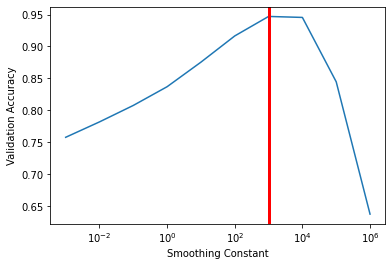

In [11]:
best_s, best_acc = sorted(validation_accuracy, key=lambda x: x[1])[-1]

plt.plot(smoothing_consts, [x[1] for x in validation_accuracy])
plt.axvline(best_s, color="red", lw=3)
plt.xlabel("Smoothing Constant")
plt.ylabel("Validation Accuracy")
plt.xscale("log")

## Evalueate test accuracy using the best model

In [12]:
class_dists = fit_gaussians(x_train, y_train, best_s)
posterior_prob_test = compute_posterior_prob(x_test, class_dists, class_priors)
y_hat = np.argmax(posterior_prob_test, axis=1)

acc = np.mean(y_hat == y_test)
print("MNIST Accuracy: {}".format(acc))

MNIST Accuracy: 0.9512


Lets also look at the mean image in each class

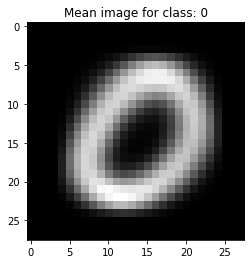

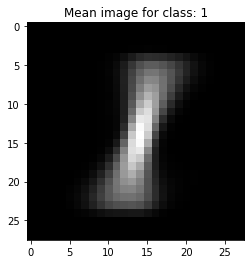

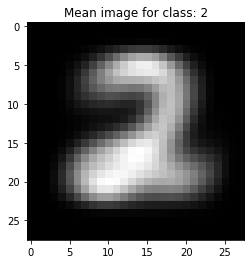

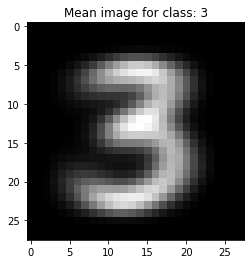

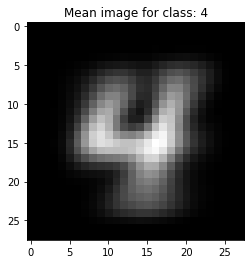

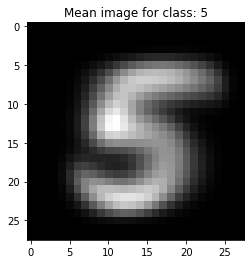

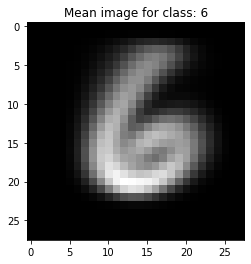

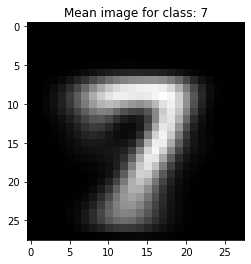

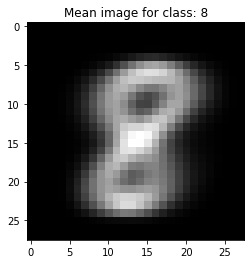

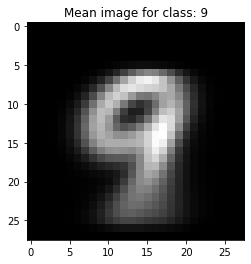

In [13]:
for ix in range(10):
    plt.imshow(class_dists[ix].mean.reshape(28,28), cmap=plt.cm.gray)
    plt.title("Mean image for class: {}".format(ix))
    plt.show()

## Plot a few examples of incorrectly classified digits

In [14]:
def pretty_probs(probs):
    ixs = np.argsort(-1*probs)
    q = ["$P_{{{:d}}}(x)={:0.3f}$".format(ix, probs[ix]) for ix in ixs]
    return " ".join(q[:5]) + "\n" + " ".join(q[5:])

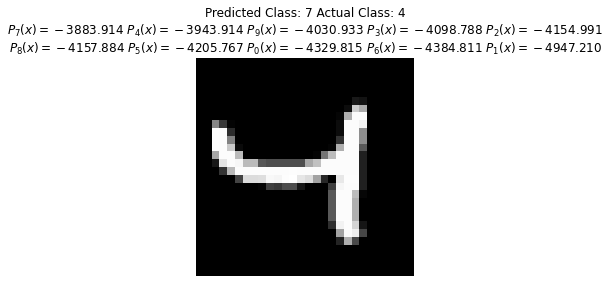

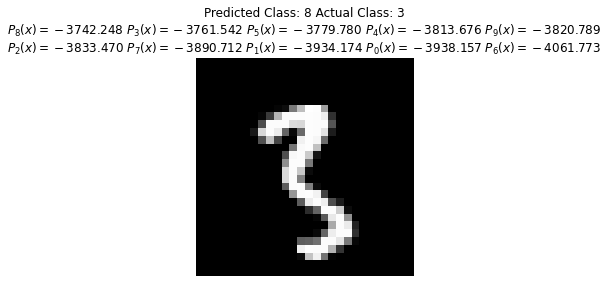

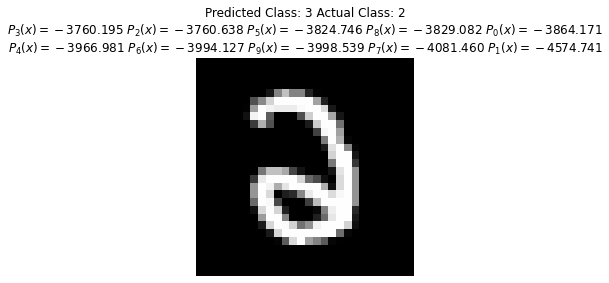

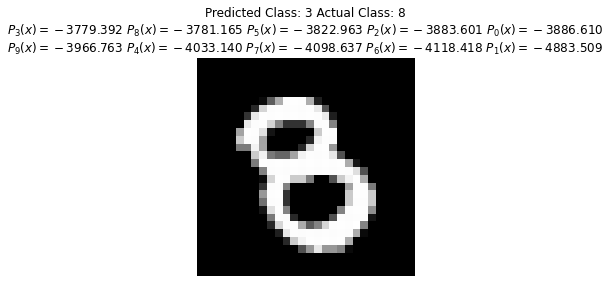

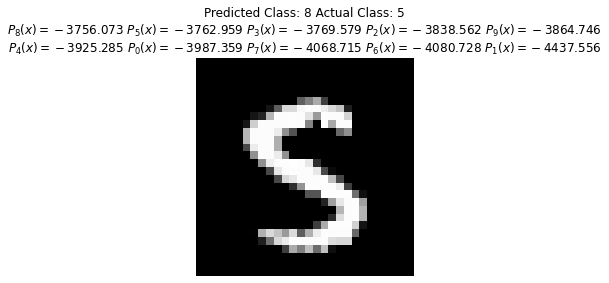

In [15]:
ixs_to_plot = np.random.choice(np.where(y_hat != y_test)[0], 5)

for ix in ixs_to_plot:
    x = x_test[ix,:]
    probs = posterior_prob_test[ix,:]
    predicted = int(np.argmax(probs))
    actual = int(y_test[ix])
    
    plt.imshow(np.reshape(x, (28,28)), cmap=plt.cm.gray)
    title = "Predicted Class: {} Actual Class: {}".format(predicted, actual)
    plt.title(title + "\n" + pretty_probs(probs))
    plt.axis('off')
    plt.show()

# Worksheet 10 Problem 2

## Read in data

In [16]:
pref = "../data/Animals_with_Attributes/"
X = np.loadtxt(pref + "predicate-matrix-continuous.txt")
y = np.loadtxt(pref + "classes.txt", dtype=str)[:,1]

## Cluster the data using K-Means with 10 clusters

In [17]:
K = KMeans(n_clusters=10)
K.fit(X)

KMeans(n_clusters=10)

## List the animals in each cluster

In [18]:
y_hat = K.predict(X)
for c in np.unique(y_hat):
    print("Cluster: {}".format(c))
    print("Animals: {}".format(", ".join(y[y_hat == c])))

Cluster: 0
Animals: skunk, mole, hamster, squirrel, rabbit, rat, weasel, mouse, raccoon
Cluster: 1
Animals: killer+whale, blue+whale, humpback+whale, seal, walrus, dolphin
Cluster: 2
Animals: dalmatian, persian+cat, german+shepherd, siamese+cat, chihuahua, collie
Cluster: 3
Animals: hippopotamus, moose, elephant, ox, rhinoceros, buffalo, pig
Cluster: 4
Animals: tiger, leopard, fox, wolf, bobcat, lion
Cluster: 5
Animals: antelope, horse, sheep, giraffe, zebra, giant+panda, deer, cow
Cluster: 6
Animals: spider+monkey, gorilla, chimpanzee
Cluster: 7
Animals: bat
Cluster: 8
Animals: beaver, otter
Cluster: 9
Animals: grizzly+bear, polar+bear


So some of these clusters make sense. For instance, cluster 4 has grizzley and polar bears which seem related, and cluster 9 has different types of hoofed mammals which also seems reasonable. However, some of these are maybe a bit strange. For instance, cluster 0 groups dogs and cats together, and cluster 3 includes domestic dogs but also large wild cats.

## Now fit using hierarchical clustering

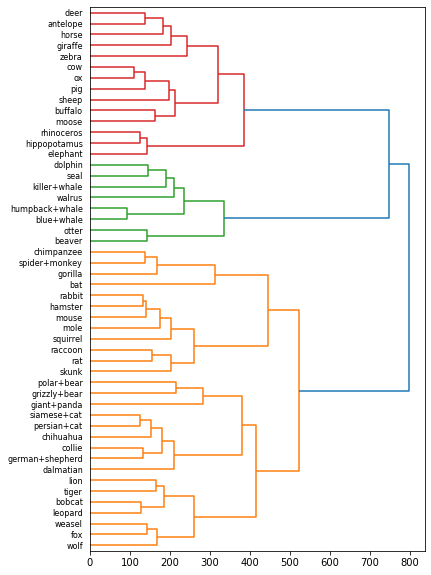

In [19]:
cl = cluster.hierarchy.linkage(y=X, method="ward")
cluster.hierarchy.dendrogram(cl, labels=y, orientation="right")
fig = plt.gcf()
fig.set_size_inches(6,10)
plt.show()

These clusters seem pretty reasonable. We see things like wolfs grouped with foxes, leopards grouped with bobcats, which is then grouped with tigers and lions. Similarly, antelopes get grouped with deer which get grouped with horses. So this seems pretty reasonable. Of course, the high level groupings are a bit corse, but that is to be expected.